In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import KernelDensity
import scipy
import utils
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans

In [2]:
from collections import defaultdict
import os
import logging

In [3]:
import pyro
import torch

In [4]:
import pyro.distributions as dist
from pyro import poutine
from pyro.infer.autoguide import AutoDelta
from pyro.optim import Adam
from pyro.infer import SVI, TraceEnum_ELBO, config_enumerate, infer_discrete

Load and test infer data

In [5]:
infer = pd.read_csv("N_infer_full_10.16.21", index_col=0)

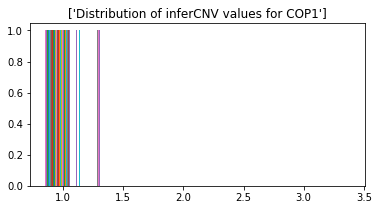

In [6]:
fig = plt.figure(figsize=(6, 3))
gene = np.random.choice(infer.columns, size=1)
plt.hist(infer[gene])
plt.title("Distribution of inferCNV values for " + gene)
plt.show()

Set macros and things for pyro

In [7]:
smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('1.8.0')

pyro.enable_validation(True)
pyro.set_rng_seed(1)
logging.basicConfig(format='%(message)s', level=logging.INFO)

# Set matplotlib settings
%matplotlib inline
plt.style.use('default')

Subsample from adadata and infer 

In [8]:
adata = sc.read_h5ad("N_ribas310_clones.h5")

In [9]:
adata_subsampled, infer_subsampled = utils.format_data(adata, infer, 200, 200)

Trying to set attribute `.uns` of view, copying.


In [10]:
infer_subsampled.shape

(800, 200)

In [11]:
infer_sub_tensor = torch.tensor(infer_subsampled)

In [12]:
infer_sub_tensor_small = torch.flatten(infer_sub_tensor).to(torch.float)
infer_tensor_big =  torch.flatten(torch.tensor(infer.to_numpy())).to(torch.float)

In [13]:
infer_tensor_big.shape

torch.Size([214211802])

In [14]:
data= infer_tensor_big[0:len(infer_tensor_big)//2]

In [15]:
infer_tensor_big.shape

torch.Size([214211802])

In [16]:
K = 3  # Fixed number of components.

@config_enumerate
def model(data):
    # Global variables.
    weights = pyro.sample('weights', dist.Dirichlet(0.5 * torch.ones(K)))
    scale = pyro.sample('scale', dist.LogNormal(0., 2.))
    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 10.))

    with pyro.plate('data', len(data)):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(weights))
        pyro.sample('obs', dist.Normal(locs[assignment], scale), obs=data)

In [17]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
elbo = TraceEnum_ELBO(max_plate_nesting=1)

In [18]:
def init_loc_fn(site):
    if site["name"] == "weights":
        # Initialize weights to uniform.
        return torch.ones(K) / K
    if site["name"] == "scale":
        return (data.var() / 2).sqrt()
    if site["name"] == "locs":
        return torch.tensor([.9,1.01,1.2])
    raise ValueError(site["name"])

def initialize(seed):
    global global_guide, svi
    pyro.set_rng_seed(seed)
    pyro.clear_param_store()
    global_guide = AutoDelta(poutine.block(model, expose=['weights', 'locs', 'scale']),
                             init_loc_fn=init_loc_fn)
    svi = SVI(model, global_guide, optim, loss=elbo)
    return svi.loss(model, global_guide, data)

# Choose the best among 100 random initializations.
loss, seed = min((initialize(seed), seed) for seed in range(100))
initialize(seed)
print('seed = {}, initial_loss = {}'.format(seed, loss))

seed = 0, initial_loss = -33554422.0


In [19]:
(infer_sub_tensor_small.var() / 2).sqrt()

tensor(0.0449)

In [ ]:
# Register hooks to monitor gradient norms.
gradient_norms = defaultdict(list)
for name, value in pyro.get_param_store().named_parameters():
    value.register_hook(lambda g, name=name: gradient_norms[name].append(g.norm().item()))

losses = []
for i in range(200 if not smoke_test else 2):
    loss = svi.step(data)
    losses.append(loss)
    print('.' if i % 100 else '\n', end='')


.....................................

<ipython-input-123-e6072454b426>:5: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.yscale('log')


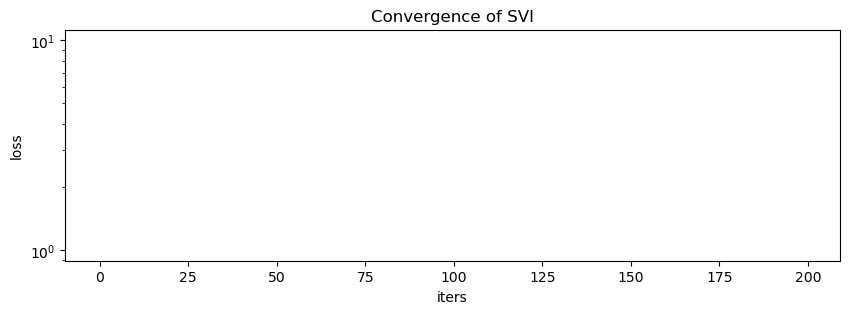

In [123]:
plt.figure(figsize=(10,3), dpi=100).set_facecolor('white')
plt.plot(losses)
plt.xlabel('iters')
plt.ylabel('loss')
plt.yscale('log')
plt.title('Convergence of SVI');

In [124]:
losses

[-26077.666015625,
 -6333.28564453125,
 -7769.66552734375,
 -24756.185546875,
 -20480.76953125,
 -20146.97265625,
 -22185.244140625,
 -24199.42578125,
 -25527.2890625,
 -25383.50390625,
 -25105.841796875,
 -25607.41796875,
 -26045.908203125,
 -25856.740234375,
 -25511.26171875,
 -25541.810546875,
 -25966.978515625,
 -26317.02734375,
 -26320.873046875,
 -26250.380859375,
 -26389.900390625,
 -26529.908203125,
 -26485.70703125,
 -26438.98828125,
 -26506.125,
 -26537.419921875,
 -26495.5625,
 -26496.171875,
 -26534.78125,
 -26523.46875,
 -26509.591796875,
 -26525.05078125,
 -26533.7578125,
 -26519.08984375,
 -26539.46875,
 -26539.962890625,
 -26538.501953125,
 -26536.451171875,
 -26544.9140625,
 -26541.865234375,
 -26541.166015625,
 -26539.462890625,
 -26546.66015625,
 -26547.359375,
 -26544.0625,
 -26548.271484375,
 -26549.701171875,
 -26540.310546875,
 -26543.01953125,
 -26539.990234375,
 -26549.41796875,
 -26546.59765625,
 -26548.5078125,
 -26542.296875,
 -26543.23046875,
 -26542.277343

In [125]:
pyro.get_param_store().named_parameters()

dict_items([('AutoDelta.weights', Parameter containing:
tensor([-0.3182, -2.2372, -1.4873], requires_grad=True)), ('AutoDelta.scale', Parameter containing:
tensor(-3.1854, requires_grad=True)), ('AutoDelta.locs', Parameter containing:
tensor([0.9889, 1.1556, 0.9887], requires_grad=True))])

In [126]:
for weight in [-0.3182, -2.2372, -1.4873]:
    print(np.exp(weight))

0.7274572824079982
0.10675700589862087
0.22598198393255894


In [127]:
np.sum(np.exp([-0.3182, -2.2372, -1.4873]))

1.060196272239178